# 卷积神经网络实践

本次作业将练习卷积神经网络，利用卷积层和全连接层实现手写数字的识别。

## 1. 目标

通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

## 2. 主要步骤

1. 获取数据
2. 定义模型结构
3. 创建模型类
4. 定义损失函数
5. 编写训练循环
6. 实施预测

### 2.1 获取数据

我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练，以及10个观测进行预测展示。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123456)
torch.manual_seed(123456)

mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10010, shuffle=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


我们一次性取出随机抽取到的10010个观测，其中 x 是图片数据，y 是图片对应的数字。

In [2]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [3]:
print(x.shape)
print(y.shape)

torch.Size([10010, 1, 28, 28])
torch.Size([10010])


将最后的10张图片取为测试集：

In [4]:
xtest = x[-10:]
ytest = y[-10:]
x = x[:-10]
y = y[:-10]
print(x.shape)
print(xtest.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10, 1, 28, 28])


我们可以利用下面的函数展示图片的内容。如选择第一张测试图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


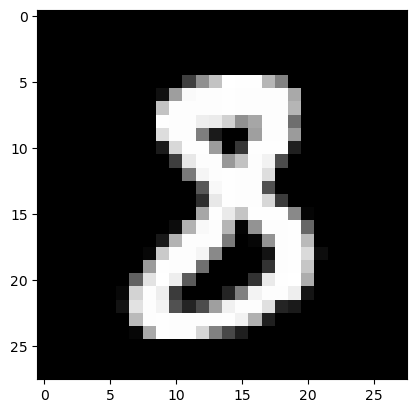

In [5]:
import matplotlib.pyplot as plt

img = xtest[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

### 2.2 定义模型结构

作为演示，我们创建一个卷积层、一个汇聚层和一个全连接层。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前6个观测，此时输入的维度是 `[6, 1, 28, 28]`：

In [6]:
ns = 6
smallx = x[0:ns]
smally = y[0:ns]
print(smallx.shape)
print(smally.shape)

torch.Size([6, 1, 28, 28])
torch.Size([6])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [7]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=2)
res1 = conv1(smallx)
print(res1.shape)

torch.Size([6, 20, 12, 12])


可以看到，输出的维度为 `[20, 12, 12]`（不包括第1位的数据批次维度）。

接下来我们创建一个最大汇聚层：

In [8]:
pool1 = torch.nn.MaxPool2d(kernel_size=2)
res2 = pool1(res1)
print(res2.shape)
assert res2.shape == (ns, 20, 6, 6), "pool1 输出形状不对"

torch.Size([6, 20, 6, 6])


可以看出此时的输出维度变成了 `[20, 6, 6]`。

最后我们将得到的特征拉直，并输出10维的向量，用来计算每个类的概率预测：

In [9]:
# 输入：20 x 6 x 6 = 720
# 输出：10
fc1 = torch.nn.Linear(in_features=720, out_features=10)
res3 = fc1(torch.flatten(res2, start_dim=1))
print(res3.shape)
assert res3.shape == (ns, 10), "fc1 输出形状不对"

torch.Size([6, 10])


### 2.3 创建模型类

在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。

In [10]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(in_features=720, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[6, 10]`，且输出结果为0到1之间的概率值。

In [11]:
np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
pred = model(smallx)
print(pred.shape)
print()
print(pred)
print()
print(torch.sum(pred, dim=1))

torch.Size([6, 10])

tensor([[0.1019, 0.1074, 0.1031, 0.1050, 0.0917, 0.1077, 0.1088, 0.0985, 0.0936,
         0.0823],
        [0.1053, 0.0975, 0.1009, 0.1096, 0.0899, 0.1213, 0.1105, 0.0947, 0.0856,
         0.0847],
        [0.0971, 0.1062, 0.1118, 0.1027, 0.0784, 0.1124, 0.1005, 0.1123, 0.0808,
         0.0979],
        [0.1053, 0.1318, 0.0929, 0.1080, 0.0824, 0.1061, 0.0934, 0.1020, 0.0958,
         0.0823],
        [0.1065, 0.0973, 0.1026, 0.1064, 0.0962, 0.1096, 0.1056, 0.1046, 0.0833,
         0.0879],
        [0.1014, 0.1099, 0.1216, 0.1017, 0.0796, 0.1058, 0.0993, 0.1093, 0.0770,
         0.0943]], grad_fn=<SoftmaxBackward0>)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [12]:
print(model)

MyModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=720, out_features=10, bias=True)
)


### 2.4 定义损失函数

对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [13]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

tensor(2.3334, grad_fn=<NllLossBackward0>)

### 2.5 编写训练循环

利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。记录每个 mini-batch 下的损失函数值存放到列表 `losses_sgd` 中，然后画出损失函数的曲线。

In [14]:
nepoch = 30
batch_size = 200
lr = 0.001

np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
losses = []
opt = torch.optim.Adam(model.parameters(), lr=lr)

n = x.shape[0]
obs_id = np.arange(n)  # [0, 1, ..., n-1]
# Run the whole data set `nepoch` times
for i in range(nepoch):
    # Shuffle observation IDs
    np.random.shuffle(obs_id)

    # Update on mini-batches
    for j in range(0, n, batch_size):
        # Create mini-batch
        x_mini_batch = x[obs_id[j:(j + batch_size)]]
        y_mini_batch = y[obs_id[j:(j + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.NLLLoss()
        loss = lossfn(torch.log(pred), y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

        if (j // batch_size) % 20 == 0:
            print(f"epoch {i}, batch {j // batch_size}, loss = {loss.item()}")

epoch 0, batch 0, loss = 2.312232255935669
epoch 0, batch 20, loss = 1.7555195093154907
epoch 0, batch 40, loss = 1.1093138456344604
epoch 1, batch 0, loss = 0.7931170463562012
epoch 1, batch 20, loss = 0.6293395757675171
epoch 1, batch 40, loss = 0.49604567885398865
epoch 2, batch 0, loss = 0.5026378035545349
epoch 2, batch 20, loss = 0.40575751662254333
epoch 2, batch 40, loss = 0.38254618644714355
epoch 3, batch 0, loss = 0.3363669514656067
epoch 3, batch 20, loss = 0.2684660255908966
epoch 3, batch 40, loss = 0.2793828845024109
epoch 4, batch 0, loss = 0.28252652287483215
epoch 4, batch 20, loss = 0.22186322510242462
epoch 4, batch 40, loss = 0.29303309321403503
epoch 5, batch 0, loss = 0.2507026195526123
epoch 5, batch 20, loss = 0.21505464613437653
epoch 5, batch 40, loss = 0.16764268279075623
epoch 6, batch 0, loss = 0.20639950037002563
epoch 6, batch 20, loss = 0.17834429442882538
epoch 6, batch 40, loss = 0.22663334012031555
epoch 7, batch 0, loss = 0.2360883504152298
epoch 7,

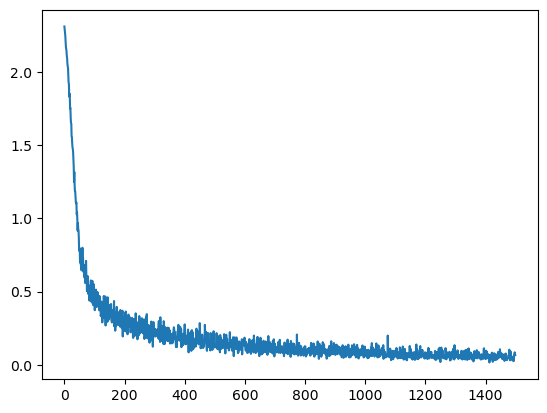

In [15]:
plt.plot(losses)

### 2.6 实施预测

为了验证模型的效果，我们对10个测试观测（即之前生成的 `testx`）进行预测。

In [16]:
ypred = model(xtest)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(ytest)

[[0.    0.    0.001 0.035 0.    0.    0.    0.    0.963 0.   ]
 [0.    0.    0.    0.    0.    0.002 0.    0.024 0.    0.973]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.982 0.    0.    0.    0.017]
 [0.978 0.    0.005 0.    0.    0.    0.001 0.    0.016 0.   ]
 [0.    0.    0.    0.001 0.008 0.    0.    0.    0.    0.991]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]]
tensor([8, 9, 2, 2, 1, 5, 0, 9, 8, 7])


如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。我们也可以让 PyTorch 自动找到最大值的位置。

In [17]:
torch.argmax(ypred, dim=1)

tensor([8, 9, 2, 2, 1, 5, 0, 9, 8, 7])

最后，我们用模型对一些真实的手写数字图片进行预测。以下是一个例子：
![](digits/sample2.png)

接下来利用 Pillow 软件包读取图片：

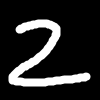

In [18]:
from PIL import Image
im = Image.open("digits/sample2.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [19]:
im_arr = np.array(im)
print(im_arr.shape)

(100, 100, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [20]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [21]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [22]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))

[[0.    0.    0.998 0.002 0.    0.    0.    0.    0.    0.   ]]
